In [1]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

In [90]:
from torchinfo import summary
from collections import OrderedDict
from networks.INR import INR
from typing import List, Tuple, Union
import matplotlib.pyplot as plt
import torch
import os

from data.DWSNets_dataset import DWSNetsDataset, LayerOneHotTransform, FlattenTransform, BiasFlagTransform, PositionEncodingTransform, MinMaxTransformer
from networks.naive_rq_ae import RQAutoencoder, RQAutoencoderConfig

In [84]:

dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(dir_path, "adl4cv", "datasets", "DWSNets", "mnist-inrs")

class AutoencoderTransform(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.bias = BiasFlagTransform()
    self.flatten = FlattenTransform()
    self.layer_one_hot = LayerOneHotTransform()

  def forward(self, x, y):
    bias, _ = self.bias(x, y)
    layer, _ = self.layer_one_hot(x, y)    
    x, _ = self.flatten(x, y)
    return torch.hstack((x, layer, bias)), y
  

class AutoencoderTransform2(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = FlattenTransform()
    self.minmax = MinMaxTransformer()
    self.encodings = PositionEncodingTransform(sigma=0.9, m=5)

  def forward(self, x, y):
    x, _ = self.flatten(x, y)
    x, _ = self.minmax(x, y)
    encodings, _ = self.encodings(x.unsqueeze(1), y)
    return torch.hstack((x, encodings)), y

dataset_no_transform = DWSNetsDataset(data_root)
dataset_flatten = DWSNetsDataset(data_root, transform=FlattenTransform())

train_dataset = DWSNetsDataset(data_root, transform=AutoencoderTransform2())
test_dataset = DWSNetsDataset(data_root, split="test", transform=AutoencoderTransform2())

path = "datasets/DWSNets/mnist-inrs/mnist_splits.json"


In [4]:

pos_enc = PositionEncodingTransform(sigma=0.9, m=2)
demo_sample = dataset_flatten[3][0].unsqueeze(1)
encoding, _ = pos_enc.forward(demo_sample, None)

In [5]:
train_dataset[0][0].size()

torch.Size([1185, 11])

In [6]:
import numpy as np

def positional_encoding(v, sigma=0.9, m=10):
    cos_part = [np.cos(2 * np.pi * (sigma ** (j / m)) * v) for j in range(m)]
    sin_part = [np.sin(2 * np.pi * (sigma ** (j / m)) * v) for j in range(m)]
    return np.array(cos_part + sin_part)

# Example usage
v = 3
sigma = 0.9
m = 1
encoding = positional_encoding(v, sigma, m)
print(encoding)

[ 1.00000000e+00 -7.34788079e-16]


In [7]:
np.cos(2 * np.pi * (sigma) * v)

-0.30901699437494806

In [8]:
pos_enc.pos_enc

PositionalEncoding()

In [9]:
train_dataset[0][0].size()[1]

11

In [76]:
ae_config = RQAutoencoderConfig(dim_enc=(dataset_flatten[0][0].size()[1], 1), dim_dec=(1, 1), activation=torch.nn.Tanh() )
ae = RQAutoencoder(ae_config)
print(ae)

1
1
RQAutoencoder(
  (encoder): Sequential(
    (encoder-linear-0): Linear(in_features=1, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (decoder-linear-0): Linear(in_features=1, out_features=1, bias=True)
  )
  (vq): ResidualVQ(
    (project_in): Identity()
    (project_out): Identity()
    (layers): ModuleList(
      (0-7): 8 x VectorQuantize(
        (project_in): Identity()
        (project_out): Identity()
        (_codebook): EuclideanCodebook()
      )
    )
  )
)


In [77]:
from training.training_autoencoder import train_model, TrainingConfig

from torch import nn
from torch.nn import MSELoss, CrossEntropyLoss, L1Loss
from torch.utils.data import DataLoader


batch_size = 2
train_dataloader = DataLoader(dataset_flatten[0][0], batch_size=batch_size, shuffle=True)
test_dataloader = train_dataloader#DataLoader([test_dataset[0][0][0]], batch_size=1, shuffle=True)

train_config = TrainingConfig()
train_config.max_iters = 50
train_config.always_save_checkpoint = True
train_config.weight_decay = 0.0
train_config.learning_rate = 1e-3
train_config.lr_decay_iters = int(train_config.max_iters*train_dataset[0][0].size()[0]/batch_size)
train_config.warmup_iters = int(0.1*train_config.max_iters*train_dataset[0][0].size()[0]/batch_size)
train_config.log_interval = 1

class AutoencoderLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.mse = L1Loss()
    self.ce = CrossEntropyLoss()

  def forward(self, pred, true):
    # take first column of pred and true and compare them with mse
    x_pred = pred[:, :1]
    x_true = true[:, :1]

    mse_loss = self.mse(x_pred, x_true)


    # compare one hot encoding (eg feature 1, 2, 3) with cross entropy loss
    layer_pred = pred[:, 1:4]
    layer_true = true[:, 1:4]
    ce_loss = self.ce(layer_pred, layer_true)

    # compare bias flag
    bias_pred = pred[:, 4]
    bias_true = true[:, 4]
    bias_loss = self.ce(bias_pred, bias_true)

    return mse_loss + ce_loss + bias_loss

ae_trained = train_model(train_config, ae_config, train_dataloader, test_dataloader, L1Loss())

1
1


  0%|          | 0/593 [00:00<?, ?it/s]/Users/luis/uni/adl4cv/adl4cv/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Epoch [1/50]: 100%|█████████▉| 592/593 [00:01<00:00, 342.29it/s, loss=1.11]/Users/luis/uni/adl4cv/adl4cv/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Checkpoint saved: models/model_epoch_49.pth


batch,▄▃▅▇▂▄▆▁▃▅█▂▅▇▆█▃▅▇▂▄▆▁▃▅█▂▁▄▆█▃▅▇▂▄▆▁▃▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▂▃▅▆██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
batch,593
epoch,49
loss,6e-05
lr,0.0


In [60]:
"""
PATH = "./models/model_epoch_499.pth"
ae_trained = RQAutoencoder(ae_config)
ae_trained.load_state_dict(torch.load(PATH)["model_state_dict"])"""


'\nPATH = "./models/model_epoch_499.pth"\nae_trained = RQAutoencoder(ae_config)\nae_trained.load_state_dict(torch.load(PATH)["model_state_dict"])'

In [78]:
dataset_flatten[0][0]


tensor([[-0.0041],
        [ 0.0303],
        [ 0.0380],
        ...,
        [-0.1311],
        [ 0.1318],
        [-0.1846]])

In [79]:
ae_trained(dataset_flatten[0][0])

tensor([[-0.0041],
        [ 0.0302],
        [ 0.0379],
        ...,
        [-0.1308],
        [ 0.1315],
        [-0.1842]], grad_fn=<AddmmBackward0>)

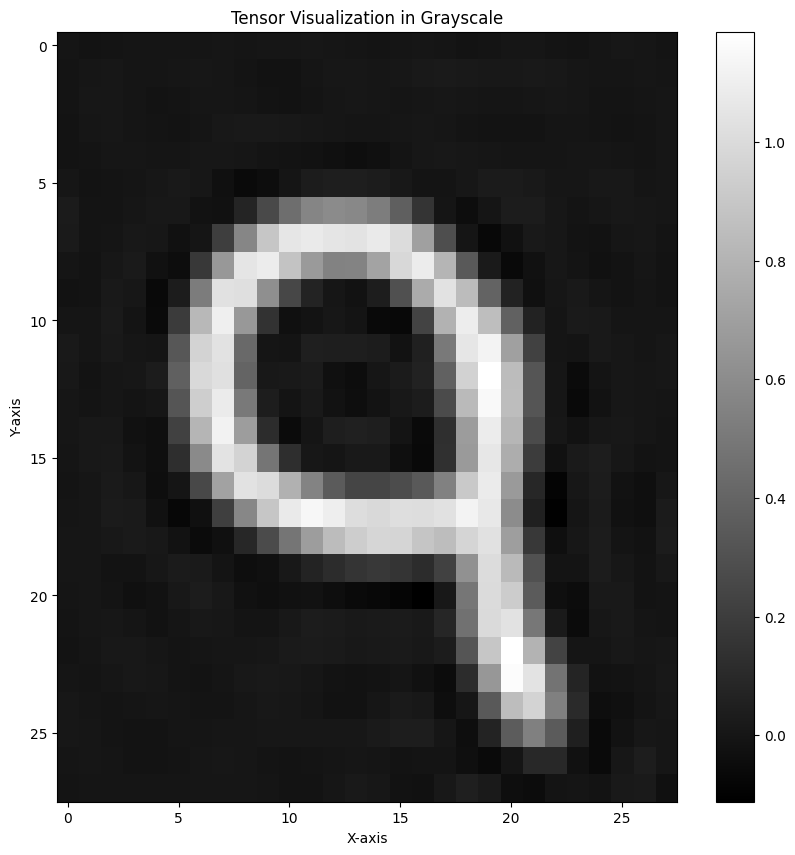

In [100]:
def backtransform_weights(flattened_weights, original_weights_dict):
    reconstructed_dict = OrderedDict()
    start = 0
    for key, tensor in original_weights_dict.items():
        # Get the number of elements in the tensor
        num_elements = tensor.numel()
        # Get the slice of the flattened weights corresponding to this tensor
        flattened_slice = flattened_weights[start:start + num_elements]
        # Reshape the slice to the shape of the original tensor
        reconstructed_tensor = flattened_slice.view(tensor.shape)
        # Add to the reconstructed dictionary
        reconstructed_dict[key] = reconstructed_tensor
        # Update the start index for the next slice
        start += num_elements
    
    return reconstructed_dict


idx = 4
dataset_ele = dataset_no_transform[idx][0]
dataset_ele_flattened= ae_trained(dataset_flatten[idx][0])

reconstructed_dict = backtransform_weights(dataset_ele_flattened, dataset_ele)

from typing import List, Tuple, Union

import numpy as np
import torch

def make_coordinates(
    shape: Union[Tuple[int], List[int]],
    bs: int,
    coord_range: Union[Tuple[int], List[int]] = (-1, 1),
) -> torch.Tensor:
    x_coordinates = np.linspace(coord_range[0], coord_range[1], shape[0])
    y_coordinates = np.linspace(coord_range[0], coord_range[1], shape[1])
    x_coordinates, y_coordinates = np.meshgrid(x_coordinates, y_coordinates)
    x_coordinates = x_coordinates.flatten()
    y_coordinates = y_coordinates.flatten()
    coordinates = np.stack([x_coordinates, y_coordinates]).T
    coordinates = np.repeat(coordinates[np.newaxis, ...], bs, axis=0)
    return torch.from_numpy(coordinates).type(torch.float)


inr_kwargs={"n_layers": 3, "in_dim": 2, "up_scale": 16}
image_size=(28, 28)

inr = INR(**inr_kwargs)
inr.load_state_dict(reconstructed_dict)
inr.eval()
input = make_coordinates(image_size, 1)
with torch.no_grad():
    image = inr(input)
    image = image.view(*image_size, -1)
    image = image.permute(2, 0, 1)

tensor = image.squeeze(0)

# Plotting the tensor as a heatmap in grayscale
plt.figure(figsize=(10, 10))
plt.imshow(tensor, cmap='gray', aspect='auto')
plt.colorbar()
plt.title('Tensor Visualization in Grayscale')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


In [87]:
data_element = dataset_no_transform[0][0]

for key in data_element.keys():
    print(key, data_element[key].size())

seq.0.weight torch.Size([32, 2])
seq.0.bias torch.Size([32])
seq.1.weight torch.Size([32, 32])
seq.1.bias torch.Size([32])
seq.2.weight torch.Size([1, 32])
seq.2.bias torch.Size([1])


In [ ]:

import numpy as np

state_dict = data_element

weights = []
shapes = []
for weight in state_dict:
    shapes.append(np.prod(state_dict[weight].shape))
    weights.append(state_dict[weight].flatten().cpu())

weights = torch.hstack(weights)
prev_weights = weights.clone()

print(weights)
print(prev_weights)

tensor([-0.0041,  0.0303,  0.0380,  ..., -0.1311,  0.1318, -0.1846])
tensor([-0.0041,  0.0303,  0.0380,  ..., -0.1311,  0.1318, -0.1846])


In [ ]:
import torch
import rff

X = torch.Tensor(range(0, 10)).unsqueeze(0)
encoding = rff.layers.PositionalEncoding(sigma=1.0, m=10)
Xp = encoding(X)
Xp.size()

torch.Size([1, 200])